### Prerequisite Packages

In [447]:
import os
import sys
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torcheval.metrics import BinaryAccuracy, BinaryPrecision, BinaryRecall, BinaryF1Score
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

sys.path.append('../')

from modules.classifier import DenseLayer, BCELoss
from modules.dataloader import load_npy_files
from modules.linear_transformation import LinearTransformations

### Model and Hyperparameter Configurations

In [448]:
# Define possible configurations for audio feature directories
audio_feature_paths = {
    'logmel': 'D:\Projects\Thesis\Audio',
    'mfcc': 'D:\Projects\Thesis\Audio 2\mfcc_extracted'
}

# Function to get the audio feature path based on the selected configuration
def get_audio_feature_path(config_name):
    if config_name in audio_feature_paths:
        return audio_feature_paths[config_name]
    else:
        raise ValueError(f"Configuration '{config_name}' not found. Available options: logmel, mfcc.")


In [449]:
torch.manual_seed(42)

### Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

### Audio Feature selection: 'logmel' or 'mfcc'
selected_config = 'logmel'
audio_features_dir = get_audio_feature_path(selected_config)

#### Data Configuration: 8 16 32 64 128
train_batch_size = 32   # Set the batch size for training data
val_batch_size = 16     # Set the batch size for validation data
test_batch_size= 16     # Set the batch size for testing data



### Hyperparameters
threshold = 0.5              # for predictions
learning_rate = 1e-5         # For optimizer
cl_dropout_rate = 0.4        # for FinalClassifier
att_dropout_rate = 0.3       # for MutualCrossAttention
num_epochs = 10              # for model training

### Classifier Configuration
isBCELoss = True                          # !!! SET ACCORDINGLY !!!
criterion = BCELoss()
# criterion = BCEWithLogits()
# criterion = CustomLoss(pos_weight=2.94)
# criterion = FocalLoss(alpha=0.25, gamma=2, pos_weight=0.34)

# !!! Choose Classifier !!! False = Dense Layer, True = Final Classifier
isFinalClassifier = False

# ### For cross validation
# num_folds = 5           # Set the number of folds for cross-validation
# batch_size = 32         # Set the batch size for cross-validation

# Define the dimensions for GMU
text_dim = 1024 
audio_dim = 768 
video_dim = 768  
output_dim = 768 

## For cross validation
num_folds = 5          # Set the number of folds for cross-validation
num_epochs_cv = 10     # Set the number of epochs for cross-validation


Device: cuda


### Dataset Class

In [450]:
class MultimodalDataset(Dataset):
    def __init__(self, id_label_df, text_features, audio_features, video_features):
        self.id_label_df = id_label_df
        
        # Convert feature lists to dictionaries for fast lookup
        self.text_features = {os.path.basename(file).split('.')[0]: tensor for file, tensor in text_features}
        self.audio_features = {os.path.basename(file).split('_')[1].split('.')[0]: tensor for file, tensor in audio_features}
        self.video_features = {os.path.basename(file).split('_')[0]: tensor for file, tensor in video_features}
        
        # List to store missing files
        self.missing_files = []
        
        # Filter out entries with missing files
        self.valid_files = self._filter_valid_files()

    def _filter_valid_files(self):
        valid_indices = []
        missing_files = []

        for idx in range(len(self.id_label_df)):
            imdbid = self.id_label_df.iloc[idx]['IMDBid']

            # Check if the IMDBid exists in each modality's features
            if imdbid in self.text_features and imdbid in self.audio_features and imdbid in self.video_features:
                valid_indices.append(idx)
            else:
                missing_files.append({'IMDBid': imdbid})

        # Filter id_label_df to only include valid rows
        self.id_label_df = self.id_label_df.iloc[valid_indices].reset_index(drop=True)
        self.missing_files = missing_files
        
        # Update valid_indices to reflect the new indices after resetting
        valid_indices = list(range(len(self.id_label_df)))

        # Return valid indices
        return valid_indices

    def __len__(self):
        return len(self.valid_files)

    def __getitem__(self, idx):
        # Get the original index from the filtered valid files
        original_idx = self.valid_files[idx]
        imdbid = self.id_label_df.iloc[original_idx]['IMDBid']
        label = self.id_label_df.iloc[original_idx]['Label']
        
        # Retrieve data from the loaded features
        text_data = self.text_features.get(imdbid, torch.zeros((1024,)))
        audio_data = self.audio_features.get(imdbid, torch.zeros((1, 197, 768)))
        video_data = self.video_features.get(imdbid, torch.zeros((95, 768)))
        
        # Define label mapping and ensure binary values
        label_map = {'red': 1.0, 'green': 0.0}
        
        try:
            label_data = torch.tensor([label_map[label]], dtype=torch.float32)
        except KeyError as e:
            print(f"Error: Label '{e}' not found in label_map.")
            raise

        return imdbid, text_data, audio_data, video_data, label_data


In [451]:
def collate_fn(batch):
    # Unpack batch elements
    imdbids, text_data, audio_data, video_data, label_data = zip(*batch)

    # Convert lists to tensors
    text_data = torch.stack(text_data)
    audio_data = torch.stack(audio_data)

    # Padding for video data
    # Determine maximum length of video sequences in the batch
    video_lengths = [v.size(0) for v in video_data]
    max_length = max(video_lengths)

    # Pad video sequences to the maximum length
    video_data_padded = torch.stack([
        F.pad(v, (0, 0, 0, max_length - v.size(0)), "constant", 0)
        for v in video_data
    ])

    # Convert labels to tensor and ensure the shape [batch_size, 1]
    label_data = torch.stack(label_data)  # Convert list of tensors to a single tensor

    return imdbids, text_data, audio_data, video_data_padded, label_data


In [452]:
def filter_video_features(video_features, lower_bound=35, upper_bound=197):
    # Assuming video_features is a list of tuples where the second element is the numpy array
    filtered_video_features = [v for v in video_features if lower_bound <= v[1].shape[0] <= upper_bound]
    return filtered_video_features


### Data Loading

In [453]:
# Load the labels DataFrame
id_label_df = pd.read_excel('../misc/MM-Trailer_dataset.xlsx')

# Define the directories
text_features_dir = 'D:\Projects\Thesis\Text'
audio_features_dir = audio_features_dir
video_features_dir = 'D:\Projects\Thesis\Video'

# Load the feature vectors from each directory
text_features = load_npy_files(text_features_dir)
audio_features = load_npy_files(audio_features_dir)
video_features = load_npy_files(video_features_dir)

video_features = filter_video_features(video_features)

print(f"Number of text feature vectors loaded: {len(text_features)}")
print(f"Number of audio feature vectors loaded: {len(audio_features)}")
print(f"Number of video feature vectors loaded: {len(video_features)}")

# Drop unnecessary columns
id_label_df = id_label_df.drop(columns=['Movie Title', 'URL'])

full_dataset = MultimodalDataset(id_label_df, text_features, audio_features, video_features)

# perform train-test split on the filtered DataFrame
train_df, val_test_df = train_test_split(
    full_dataset.id_label_df, test_size=0.3, random_state=42, stratify=full_dataset.id_label_df['Label'])

# Further splitting remaining set into validation and test sets
val_df, test_df = train_test_split(
    val_test_df, test_size=0.5, random_state=42, stratify=val_test_df['Label'])

print("train_df shape:", train_df.shape)
print("val_df shape:", val_df.shape)
print("test_df shape:", test_df.shape)

print("Train label distribution:", train_df['Label'].value_counts())
print("Validation label distribution:", val_df['Label'].value_counts())
print("Test label distribution:", test_df['Label'].value_counts())

print("-" * 40)

# create datasets based on these splits
train_dataset = MultimodalDataset(train_df, text_features, audio_features, video_features)
val_dataset = MultimodalDataset(val_df, text_features, audio_features, video_features)
test_dataset = MultimodalDataset(test_df, text_features, audio_features, video_features)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn, generator=torch.Generator().manual_seed(42))
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=True, num_workers=0, collate_fn=collate_fn, generator=torch.Generator().manual_seed(42))
test_dataloader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn, generator=torch.Generator().manual_seed(42))

# Function to calculate and print the size of each DataLoader
def print_dataloader_sizes(dataloader, name):
    total_samples = len(dataloader.dataset)  # Get the size of the dataset
    num_batches = len(dataloader)  # Get the number of batches
    print(f"{name} DataLoader: Total Samples = {total_samples}, Number of Batches = {num_batches}")

# Print sizes of each DataLoader
print_dataloader_sizes(train_dataloader, "Train")
print_dataloader_sizes(val_dataloader, "Validation")
print_dataloader_sizes(test_dataloader, "Test")



Number of text feature vectors loaded: 1353
Number of audio feature vectors loaded: 1353
Number of video feature vectors loaded: 1325
train_df shape: (927, 2)
val_df shape: (199, 2)
test_df shape: (199, 2)
Train label distribution: Label
green    693
red      234
Name: count, dtype: int64
Validation label distribution: Label
green    149
red       50
Name: count, dtype: int64
Test label distribution: Label
green    149
red       50
Name: count, dtype: int64
----------------------------------------
Train DataLoader: Total Samples = 927, Number of Batches = 29
Validation DataLoader: Total Samples = 199, Number of Batches = 13
Test DataLoader: Total Samples = 199, Number of Batches = 13


### GMU Class

In [454]:
# Class for Gated Multimodal Unit of Arevalo et al. (2017)
class GatedMultimodalUnit(torch.nn.Module):
    def __init__(self, text_dim, audio_dim, video_dim, output_dim):
        super(GatedMultimodalUnit, self).__init__()
        
        # Linear transformation for text
        self.text_linear = LinearTransformations(text_dim, output_dim)
        
        # Convolutional layers for audio and video features
        self.audio_conv = nn.Conv1d(audio_dim, output_dim, kernel_size=1)
        self.video_conv = nn.Conv1d(video_dim, output_dim, kernel_size=1)
        
        self.output_dim = output_dim 
        
        # Activation functions
        self.activation = nn.Tanh()
        self.gate_activation = nn.Sigmoid()
        
        # Weight matrices for each modality
        self.W1 = nn.Parameter(torch.Tensor(output_dim, output_dim))
        self.W2 = nn.Parameter(torch.Tensor(output_dim, output_dim))
        self.W3 = nn.Parameter(torch.Tensor(output_dim, output_dim))
        
        # Gating matrices
        self.Y1 = nn.Parameter(torch.Tensor(output_dim, output_dim))
        self.Y2 = nn.Parameter(torch.Tensor(output_dim, output_dim))
        self.Y3 = nn.Parameter(torch.Tensor(output_dim, output_dim))
        
        # Initialize weights
        self._initialize_weights()
        
    def _initialize_weights(self):
        
        # Initialize weight matrices
        init.xavier_uniform_(self.W1)
        init.xavier_uniform_(self.W2)
        init.xavier_uniform_(self.W3)
        
        # Initialize gating matrices
        init.xavier_uniform_(self.Y1)
        init.xavier_uniform_(self.Y2)
        init.xavier_uniform_(self.Y3)
        
        
    def forward(self, text_features, audio_features, video_features):

        # Process text features to match shape
        x_t = self.text_linear(text_features)              # Shape: [batch_size, output_dim]

        # Process audio features to match shape
        audio_features = audio_features.squeeze(1).permute(0, 2, 1)               # Shape: [batch_size, audio_dim, sequence_length] 
        x_a = self.audio_conv(audio_features).mean(dim=-1)              # Shape: [batch_size, output_dim]

        # Process video features to match shape
        video_features = video_features.permute(0, 2, 1)   # Shape: [batch_size, video_dim, sequence_length]
        x_v = self.video_conv(video_features).mean(dim=-1)              # Shape: [batch_size, output_dim]
 
        h1 = self.activation(torch.matmul(x_t, self.W1))        # Shape: [batch_size, output_dim]
        h2 = self.activation(torch.matmul(x_a, self.W2))        # Shape: [batch_size, output_dim]
        h3 = self.activation(torch.matmul(x_v, self.W3))        # Shape: [batch_size, output_dim]
        
        # Compute modality-specific gating weights
        z1 = self.gate_activation(torch.matmul(x_t, self.Y1))  # Shape: [batch_size, output_dim]
        z2 = self.gate_activation(torch.matmul(x_a, self.Y2))  # Shape: [batch_size, output_dim]
        z3 = self.gate_activation(torch.matmul(x_v, self.Y3))  # Shape: [batch_size, output_dim]
        
        # Calculate final output
        h = z1 * h1 + z2 * h2 + z3 * h3         

        return h


### Classifier

In [455]:
class FinalClassifier(nn.Module):
    def __init__(self, input_size, dropout_rate=0.5):
        super(FinalClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)  # From 2304 to 2048
        self.fc2 = nn.Linear(1024, 512)        # From 2048 to 1024
        # self.fc3 = nn.Linear(1024, 512)         # Optional 512 or 768

        self.dropout = nn.Dropout(dropout_rate)
        self.dense = nn.Linear(512, 1)          # Final output layer
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)

        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)

        # x = self.fc3(x)
        # x = self.relu(x)

        x = self.dense(x)
        if isBCELoss:
            x = self.sigmoid(x)
        return x


### Model Training Functions

In [456]:
def get_optimizer(parameters, lr=learning_rate):
    # Create an optimizer, for example, Adam
    return optim.Adam(parameters, lr=lr)

In [463]:
def train_model(model, dense_layer, dataloader, criterion, optimizer, device, 
                output_dir='results/gmu/', output_filename='train_predictions.csv',
                output_dim=768):
    model.train()
    dense_layer.train()
    total_loss = 0
    
    os.makedirs(output_dir, exist_ok=True)
    
    # Initialize metrics
    precision_metric = BinaryPrecision().to(device)
    recall_metric = BinaryRecall().to(device)
    f1_metric = BinaryF1Score().to(device)
    accuracy_metric = BinaryAccuracy().to(device)
    
    results = []
    
    for imdbids, text_features, audio_features, video_features, targets in dataloader:
        # Move all inputs to device
        text_features = text_features.to(device)
        audio_features = audio_features.to(device)
        video_features = video_features.to(device)
        targets = targets.to(device)
        
        # Ensure targets are properly shaped and typed
        targets = targets.view(-1).float()
        
        # Forward pass through GMU
        outputs = model(text_features, audio_features, video_features)
        outputs = outputs.view(outputs.size(0), -1)
        
        # Forward pass through dense layer
        predictions = dense_layer(outputs)
        predictions = predictions.view(-1)  # Reshape to [batch_size]
        
        # Compute loss
        loss = criterion(predictions, targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Apply sigmoid if not using BCELoss
        if not isBCELoss:
            predictions = torch.sigmoid(predictions)
        
        # Get binary predictions
        binary_preds = (predictions >= threshold).float()
        
        # Update metrics
        precision_metric.update(binary_preds.long(), targets.long())
        recall_metric.update(binary_preds.long(), targets.long())
        f1_metric.update(binary_preds.long(), targets.long())
        accuracy_metric.update(binary_preds.long(), targets.long())
        
        # Store results
        for i in range(len(imdbids)):
            results.append({
                'IMDBid': imdbids[i],
                'Raw Prediction': predictions[i].item(),
                'Binary Prediction': binary_preds[i].item(),
                'Target': targets[i].item()
            })
    
    # Compute metrics
    train_precision = precision_metric.compute().item()
    train_recall = recall_metric.compute().item()
    train_f1_score = f1_metric.compute().item()
    train_accuracy = accuracy_metric.compute().item()
    
    train_average_loss = total_loss / len(dataloader)
    
    # Save results
    results_df = pd.DataFrame(results)
    output_filepath = os.path.join(output_dir, output_filename)
    results_df.to_csv(output_filepath, index=False)
    
    return train_average_loss, train_accuracy, train_precision, train_recall, train_f1_score

In [469]:
def evaluate_model(model, dense_layer, dataloader, criterion, device,
                  output_dir='results/', output_filename='val_predictions.csv',
                  output_dim=768):
    model.eval()
    dense_layer.eval()
    total_loss = 0
    
    os.makedirs(output_dir, exist_ok=True)
    
    # Initialize metrics
    precision_metric = BinaryPrecision().to(device)
    recall_metric = BinaryRecall().to(device)
    f1_metric = BinaryF1Score().to(device)
    accuracy_metric = BinaryAccuracy().to(device)
    
    results = []
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for imdbids, text_features, audio_features, video_features, targets in dataloader:
            # Move all inputs to device
            text_features = text_features.to(device)
            audio_features = audio_features.to(device)
            video_features = video_features.to(device)
            targets = targets.to(device)
            
            # Ensure targets are properly shaped and typed
            targets = targets.view(-1).float()
            
            # Forward passes
            outputs = model(text_features, audio_features, video_features)
            outputs = outputs.view(outputs.size(0), -1)
            predictions = dense_layer(outputs)
            predictions = predictions.view(-1)  # Reshape to [batch_size]
            
            # Compute loss
            loss = criterion(predictions, targets)
            total_loss += loss.item()
            
            # Apply sigmoid if not using BCELoss
            if not isBCELoss:
                predictions = torch.sigmoid(predictions)
            
            # Get binary predictions
            binary_preds = (predictions >= threshold).float()
            
            # Store predictions and targets for confusion matrix
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            
            # Update metrics
            precision_metric.update(binary_preds.long(), targets.long())
            recall_metric.update(binary_preds.long(), targets.long())
            f1_metric.update(binary_preds.long(), targets.long())
            accuracy_metric.update(binary_preds.long(), targets.long())
            
            # Store results
            for i in range(len(imdbids)):
                results.append({
                    'IMDBid': imdbids[i],
                    'Raw Prediction': predictions[i].item(),
                    'Binary Prediction': binary_preds[i].item(),
                    'Target': targets[i].item()
                })
    
    # Compute metrics
    val_precision = precision_metric.compute().item()
    val_recall = recall_metric.compute().item()
    val_f1_score = f1_metric.compute().item()
    val_accuracy = accuracy_metric.compute().item()
    
    val_average_loss = total_loss / len(dataloader)
    
    # Calculate confusion matrix
    val_conf_matrix = confusion_matrix(all_targets, np.round(all_predictions))
    
    # Save results
    results_df = pd.DataFrame(results)
    output_filepath = os.path.join(output_dir, output_filename)
    results_df.to_csv(output_filepath, index=False)
    
    return val_average_loss, val_accuracy, val_precision, val_recall, val_f1_score, val_conf_matrix

In [470]:
def test_model(
    model, 
    dense_layer, 
    dataloader, 
    criterion, 
    device,
    output_dir='results/test/', 
    output_filename='test_predictions.csv',
    output_dim=768
):

    model.eval()
    dense_layer.eval()
    total_loss = 0

    os.makedirs(output_dir, exist_ok=True)

    # Initialize metrics for binary classification
    precision_metric = BinaryPrecision().to(device)
    recall_metric = BinaryRecall().to(device)
    f1_metric = BinaryF1Score().to(device)
    accuracy_metric = BinaryAccuracy().to(device) 
    
    # Reset metrics at the start of testing
    precision_metric.reset()
    recall_metric.reset()
    f1_metric.reset()
    accuracy_metric.reset()

    # List to collect results for CSV
    results = []
    all_targets = []
    all_predictions = []

    print("-" * 20, "Test", "-" * 20)

    with torch.no_grad():
        for imdbids, text_features, audio_features, video_features, targets in dataloader:
            text_features, audio_features, video_features, targets = (
                text_features.to(device),
                audio_features.to(device),
                video_features.to(device),
                targets.to(device)
            )
            
            # Pass inputs through GMU model
            outputs = model(text_features, audio_features, video_features)

            outputs = outputs.view(outputs.size(0), -1)  # Shape will be [batch_size, 153600]
            
            # Pass the GMU outputs through the dense layer to get final predictions
            predictions = dense_layer(outputs).view(-1) # Shape: [batch_size, 1]

            targets =targets.squeeze()
            targets = targets.float()
            
            # Compute loss
            loss = criterion(predictions, targets)
            total_loss += loss.item()

            # Apply sigmoid if BCELoss is not used
            if not isBCELoss:
                predictions = torch.sigmoid(predictions)

            # Apply threshold to get binary predictions
            preds = (predictions >= threshold).float()

            preds = preds.squeeze()
            targets = targets.squeeze()

            # Collect results for each sample
            for i in range(len(imdbids)):
                results.append({
                    'IMDBid': imdbids[i],
                    'Raw Prediction': predictions[i].item(),
                    'Binary Prediction': preds[i].item(),
                    'Target': targets[i].item()
                })
            
            # Update metrics for binary classification
            precision_metric.update(preds.long(), targets.long())
            recall_metric.update(preds.long(), targets.long())
            f1_metric.update(preds.long(), targets.long())
            accuracy_metric.update(preds.long(), targets.long())

    # Compute average precision, recall, F1 score, and accuracy
    test_precision = precision_metric.compute().item()
    test_recall = recall_metric.compute().item()
    test_f1_score = f1_metric.compute().item()
    test_accuracy = accuracy_metric.compute().item() 

    test_average_loss = total_loss / len(dataloader)

    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test F1 Score: {test_f1_score:.4f}")
    print(f"Test Loss: {test_average_loss:.4f}")
    
    # Create DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    output_filepath = os.path.join(output_dir, output_filename)
    results_df.to_csv(output_filepath, index=False, header=True)

    # Calculate confusion matrix
    test_conf_matrix = confusion_matrix(all_targets, np.round(all_predictions))

    return test_average_loss, test_accuracy, test_precision, test_recall, test_f1_score, test_conf_matrix


### Model Training

In [471]:
def plot_confusion_matrix(conf_matrix, class_names=['Negative', 'Positive']):
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [472]:
# Function to plot training and validation loss
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', color='blue', marker='o')
    plt.plot(val_losses, label='Validation Loss', color='orange', marker='x')
    plt.title('Training and Validation Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [473]:
if __name__ == "__main__":
    torch.manual_seed(42)
    
    # Set device configuration
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Device: {device}")

    # Initialize the SMCA model A
    model = GatedMultimodalUnit(text_dim=text_dim, audio_dim=audio_dim, video_dim=video_dim, output_dim=output_dim).to(device)

    # Determine the output dimensions
    output_dim = 768

    # Own DenseLayer or FinalClassifier
    if isFinalClassifier:
        dense_layer = FinalClassifier(output_dim).to(device) 
    else:
        dense_layer = DenseLayer(output_dim).to(device)

    optimizer = get_optimizer(list(dense_layer.parameters()), learning_rate)
    
    # Lists to store the training and validation losses
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        print("-" * 40)
        print(f"Epoch {epoch + 1}/{num_epochs}")

        # Ensure you have a dataloader that yields inputs and targets
        train_average_loss, train_accuracy, train_precision, train_recall, train_f1_score = train_model(model=model, dense_layer=dense_layer, dataloader=train_dataloader, criterion=criterion, optimizer=optimizer, device=device, output_dim=output_dim)
        train_losses.append(train_average_loss)  # Store training loss

        print("-" * 20, "Train", "-" * 20)
        print(f"Train Accuracy: {train_accuracy:.4f}")
        print(f"Train Precision: {train_precision:.4f}")
        print(f"Train Recall: {train_recall:.4f}")
        print(f"Train F1 Score: {train_f1_score:.4f}")
        print(f"Train Loss: {train_average_loss:.4f}")
    
        
        for name, param in model.named_parameters():
            if param.grad is None:
                print("After train: model:", "No gradient for:", name)
        
        for name, param in dense_layer.named_parameters():
            if param.grad is None:
                print("After train: classifier:", "No gradient for:", name)

        # Validate step
        val_average_loss, val_accuracy, val_precision, val_recall, val_f1_score, val_conf_matrix = evaluate_model(model=model, dense_layer=dense_layer, dataloader=val_dataloader, criterion=criterion, device=device, output_dim=output_dim)
        val_losses.append(val_average_loss)  # Store validation loss
        
        print("-" * 20, "Eval", "-" * 20)
        print(f"Eval Accuracy: {val_accuracy:.4f}")
        print(f"Eval Precision: {val_precision:.4f}")
        print(f"Eval Recall: {val_recall:.4f}")
        print(f"Eval F1 Score: {val_f1_score:.4f}")
        print(f"Eval Loss: {val_average_loss:.4f}")
        
        # print(f"Training Loss: {train_average_loss:.4f}, Validation Loss: {eval_average_loss:.4f}")

    # Testing the model
    print("-" * 40)
    print("Testing the model on the test set...")
    test_average_loss, test_accuracy, test_precision, test_recall, test_f1_score, test_conf_matrix = test_model(model=model, dense_layer=dense_layer, dataloader=test_dataloader, criterion=criterion, device=device, output_dim=output_dim)
    
    print("-" * 20, "Test", "-" * 20)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test F1 Score: {test_f1_score:.4f}")
    print(f"Test Loss: {test_average_loss:.4f}")
    
    # Summary of metrics
    metrics_summary = {
        "Train Accuracy": [train_accuracy],
        "Validation Accuracy": [val_accuracy],
        "Test Accuracy": [test_accuracy],
        "Train Precision": [train_precision],
        "Validation Precision": [val_precision],
        "Test Precision": [test_precision],
        "Train Recall": [train_recall],
        "Validation Recall": [val_recall],
        "Test Recall": [test_recall],
        "Train F1 Score": [train_f1_score],
        "Validation F1 Score": [val_f1_score],
        "Test F1 Score": [test_f1_score],
        "Train Loss": [train_average_loss],
        "Validation Loss": [val_average_loss],
        "Test Loss": [test_average_loss]
    }
    
    # Create DataFrame
    metrics_df = pd.DataFrame(metrics_summary)

Device: cuda
----------------------------------------
Epoch 1/10
-------------------- Train --------------------
Train Accuracy: 0.7314
Train Precision: 0.2727
Train Recall: 0.0385
Train F1 Score: 0.0674
Train Loss: 0.6709
-------------------- Eval --------------------
Eval Accuracy: 0.7387
Eval Precision: 0.2500
Eval Recall: 0.0200
Eval F1 Score: 0.0370
Eval Loss: 0.6691
----------------------------------------
Epoch 2/10
-------------------- Train --------------------
Train Accuracy: 0.7443
Train Precision: 0.3636
Train Recall: 0.0171
Train F1 Score: 0.0327
Train Loss: 0.6653
-------------------- Eval --------------------
Eval Accuracy: 0.7487
Eval Precision: 0.5000
Eval Recall: 0.0200
Eval F1 Score: 0.0385
Eval Loss: 0.6637
----------------------------------------
Epoch 3/10
-------------------- Train --------------------
Train Accuracy: 0.7487
Train Precision: 0.6000
Train Recall: 0.0128
Train F1 Score: 0.0251
Train Loss: 0.6602
-------------------- Eval --------------------
Eval A

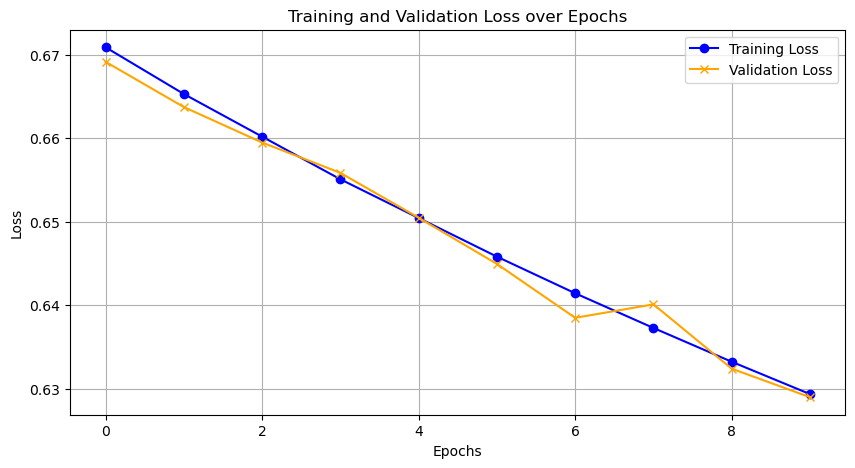

In [474]:
plot_losses(train_losses, val_losses)

In [475]:
plot_confusion_matrix(test_conf_matrix)

ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 600x500 with 0 Axes>

In [ ]:
# Display the table
metrics_df

In [ ]:
# if __name__ == '__main__':
#     kf = KFold(n_splits=n_splits, shuffle=True)

#     # Initialize lists to collect metrics across all folds
#     total_train_losses = []
#     total_val_losses = []
#     total_train_accuracies = []
#     total_val_accuracies = []
#     total_train_precisions = []
#     total_val_precisions = []
#     total_train_recalls = []
#     total_val_recalls = []
#     total_train_f1_scores = []
#     total_val_f1_scores = []

#     for fold, (train_index, val_index) in enumerate(kf.split(full_dataset), 1):
#         print("-" * 50)
#         print(f"Fold {fold}/{n_splits}")

#         # Create subsets for training and validation
#         train_subset = Subset(full_dataset, train_index)
#         val_subset = Subset(full_dataset, val_index)
        
#         # DataLoaders with batch size 8 and collate function
#         train_loader = DataLoader(train_subset, batch_size=8, shuffle=True, num_workers=0, collate_fn=collate_fn)
#         val_loader = DataLoader(val_subset, batch_size=8, shuffle=False, num_workers=0, collate_fn=collate_fn)
        
#         # Initialize the model and dense layer for the current fold
#         model = GatedMultimodalUnit(text_dim=text_dim, audio_dim=audio_dim, video_dim=video_dim, output_dim=output_dim).to(device)

#         if isFinalClassifier:
#             dense_layer = FinalClassifier(input_size=output_dim).to(device) 
#         else:
#             dense_layer = DenseLayer(output_dim).to(device)
        
#         # Combine parameters of GMU model and DenseLayer for the optimizer
#         optimizer = get_optimizer(list(model.parameters()) + list(dense_layer.parameters()))
        
#         print(f"Training model for fold {fold}")
#         train_average_loss, train_accuracy, train_precision, train_recall, train_f1_score = train_model(
#             model=model,
#             dense_layer=dense_layer,
#             dataloader=train_loader,
#             criterion=criterion,
#             optimizer=optimizer,
#             device=device
#         )
        
#         # Store training metrics
#         total_train_losses.append(train_average_loss)


#         print(f"Evaluating model for fold {fold}")
#         eval_average_loss, eval_accuracy, eval_precision, eval_recall, eval_f1_score, eval_conf_matrix = evaluate_model(
#             model=model,
#             dense_layer=dense_layer,
#             dataloader=val_loader,
#             criterion=criterion,
#             device=device
#         )
        
#         # Store validation metrics
#         total_val_losses.append(eval_average_loss)


#     # Compute averages for cross-validation results
#     average_cv_loss = sum(total_val_losses) / n_splits
#     average_cv_precision = sum(total_val_precisions) / n_splits
#     average_cv_recall = sum(total_val_recalls) / n_splits
#     average_cv_f1 = sum(total_val_f1_scores) / n_splits
#     average_cv_accuracy = sum(total_val_accuracies) / n_splits

#     print(f"Average Cross-Validation Loss: {average_cv_loss:.4f}")
#     print(f"Average Cross-Validation Precision: {average_cv_precision:.4f}")
#     print(f"Average Cross-Validation Recall: {average_cv_recall:.4f}")
#     print(f"Average Cross-Validation F1 Score: {average_cv_f1:.4f}")
#     print(f"Average Cross-Validation Accuracy: {average_cv_accuracy:.4f}")

#     # Summary of metrics
#     metrics_summary = {
#         "Train Accuracy": total_train_accuracies,
#         "Validation Accuracy": total_val_accuracies,
#         "Train Precision": total_train_precisions,
#         "Validation Precision": total_val_precisions,
#         "Train Recall": total_train_recalls,
#         "Validation Recall": total_val_recalls,
#         "Train F1 Score": total_train_f1_scores,
#         "Validation F1 Score": total_val_f1_scores,
#         "Train Loss": total_train_losses,
#         "Validation Loss": total_val_losses,
#     }

#     # Create DataFrame and save to CSV
#     metrics_df = pd.DataFrame(metrics_summary)
#     metrics_df.to_csv("cross_validation_metrics_summary.csv", index=False)
